<a href="https://colab.research.google.com/github/BRomans/IdMind/blob/main/svm_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Run this cell to load required libraries and mount your Drive folder
import numpy as np
from numpy.random import choice
from matplotlib import pyplot as plt
from google.colab import drive
import os
from sklearn.svm import SVC
from sklearn.base import clone
from sklearn.metrics import accuracy_score, precision_score, recall_score
import pandas as pd
import itertools
import random
from time import time

In [2]:
# Seed value
seed_value = 10

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

In [3]:
drive.mount('/content/drive')
dirpath = "/content/drive/MyDrive/ml2-eeg-biometrics/train-test-data/" 

Mounted at /content/drive


In [8]:
class SVM_one_v_all:
  def __init__(self, C=1.0, kernel='rbf', degree=3, gamma='scale', random_state=None, verification=False):
    """ Initialise the instance, saving the relevant parameters. """
    self.C = C
    self.kernel = kernel
    self.degree = degree
    self.gamma = gamma
    self.random_state = random_state
    self.svm = SVC(C=C, kernel=kernel, degree=degree, gamma=gamma, random_state=random_state, probability=True)
    self.verification=verification

  def fit(self, x_train, y_train, size_factor = 3, verbose=True):
    """ Fit a multi-class classifier using SVM one-vs-all approach. 
    Input:
      x_train       2D array of feature values.
      y_train       1D array of class labels for the training data.
      size_factor   integer specifying the ratio of negative to positive examples for each binary classifier. Currently not used.  
      verbose       boolean, if set to True then each class label is printed when its classifier is being trained.
    Output:
      None          x_train, y_train, unique class labels, and a list of binary SVMs are saved to the instance. 
    """
    self.y_train = y_train
    self.x_train = x_train
    class_values = np.unique(y_train)
    self.class_values = class_values
    svm_list = []

    for c in class_values:
      if verbose: print(c)
      c_inds = np.where(y_train == c)[0]

      non_c_inds = np.where(y_train != c)[0]
      size_factor = size_factor if size_factor < len(non_c_inds)/len(c_inds) else len(non_c_inds)/len(c_inds)

      # non_c_inds = choice(non_c_inds, size=int(len(c_inds)*size_factor), replace=False)                 # Take random subset of examples of other classes. size = the number of positive class examples times a user-specified size_factor.
      
      x_subset = np.zeros((len(c_inds)+len(non_c_inds), x_train.shape[1]))
      y_subset = np.zeros(len(c_inds)+len(non_c_inds))

      x_subset[:len(c_inds),:] = x_train[c_inds,:]
      x_subset[len(c_inds):,:] = x_train[non_c_inds,:]

      y_subset[:len(c_inds)] = 1

      clf = clone(self.svm)
      clf.fit(x_subset, y_subset)

      svm_list.append(clf)
    
    self.svm_list = svm_list

  def predict(self, x_test, verbose=True, class_ver=None, return_probs=False):
    """ Predict the class label, given observed feature values 
    Input:
      x_test        2D array of feature values.
      verbose       boolean, if set to True then each class label is printed when its respective classifier is being evaluated.
      class_ver     integer (class), if specified then the model verifies (predicts) whether each sample is from the specified class or not, rather than identifying the class.
      return_probs  boolean, if set to true then the probabilities are returned as well as the class predictions.
    Returns:
      preds       1D array of class predictions.
      probs       1D array of likelihoods for the predicted classes. Returned only if return_probs set to true in the call to predict().
    """
    class_values = self.class_values

    if not self.verification:
      preds = np.zeros(len(x_test))
      max_probs = np.zeros(len(x_test))

      for i, model in enumerate(self.svm_list):
        if verbose: print(class_values[i])
        probs = model.predict_proba(x_test)[:,1]
        
        preds[probs > max_probs] = class_values[i]
        max_probs[probs > max_probs] = probs[probs > max_probs]

    elif class_ver is not None:
      class_ind = np.where(class_values == class_ver)[0][0]
      print(class_ind)

      preds = self.svm_list[class_ind].predict(x_test)
    
    else:
      raise ValueError("verification is set to True, please supply class_ver.")
    
    if return_probs:
      return preds, max_probs
    else:
      return preds

  def grid_search(self, x_train, y_train, x_valid, y_valid, params, data_name=''):
    """ Fit & evaluate models using a given set of parameters. Write results to file.
    Input:
      x_train     2D array of feature values.
      y_train     1D array of class labels for the training data.
      x_valid     2D array of feature values to be used for prediction and validation.
      y_valid     1D array of class labels for the validation data.
      params      Dictionary of parameters to try including, kernel, C, gamma and degree.
      data_name   String to be added to the output to file for tracking purposes.
    Returns:
      None        prints & writes results to file.
    """
    if  len(params['kernel'])==0 | len(params['C'])==0 | len(params['gamma'])==0 | len(params['degree'])==0:
      raise ValueError("At least one value must be supplied for kernel, C, gamma, and degree.")

    count=0
    filepath = '/content/drive/MyDrive/ml2-eeg-biometrics/classification-results.csv'

    for kernel in params['kernel']:
      for C in params['C']:
        for gamma in params['gamma']:
          for degree in params['degree']:
            print("-"*40)
            print("{}: kernel: {}, C: {}, gamma: {}, degree: {}".format(count, kernel, C, gamma, degree))
            self.svm = SVC(C=C, kernel=kernel, degree=degree, gamma=gamma, random_state=self.random_state, probability=True)

            print(' Fitting....')
            self.fit(x_train, y_train, verbose=False)

            print(' Calculating results....')
            train_pred = self.predict(x_train, verbose=False)
            train_acc = accuracy_score(y_train, train_pred)
            print("train_acc: {0:.3f}".format(train_acc))

            valid_pred = self.predict(x_valid, verbose=False)
            valid_acc = accuracy_score(y_valid, valid_pred)
            print("validation_acc: {0:.3f}".format(valid_acc))

            mode = 'a' if os.path.isfile(filepath) else 'w'

            timestamp = pd.Timestamp.now()
            line = ','.join(map(str, [data_name,count,timestamp,kernel,C,gamma,degree,train_acc,valid_acc]))
            print(line)
            with open(filepath, mode) as file:
              file.write(line + '\n')

            count+=1

  def add_test_class(self, x_test, y_test, id_test):
    """ 
    Add an unseen participant to the system and test the results. 
    Separates the test data into the 6 runs, trains a model on 5 runs and tests the results on the left out run - similar to 6-fold cross validation.
    Input:
      x_test    2D array of feature values for the unseen participant
      y_test    1D array of class labels for the unseen participant - should contain only one unique class label.
      id_test   2D array of session information for the unseen participant, so the individual runs can be split.
    Returns:
      train_scores  List of training accuracies from the 6 models trained.
      test_scores   List of test accuracies on the left-out run of each of the 6 models.
    """
    if len(np.unique(y_test)) != 1:
      raise ValueError("More than one class found in y_test.")

    class_values = self.class_values
    svm_list = self.svm_list

    new_class = np.unique(y_test)[0]
    class_values = np.append(class_values, new_class)                             # Add the new class to the array of classes.

    clf = clone(self.svm)
    svm_list.append(clf)

    self.svm_list = svm_list
    self.class_values = class_values

    train_scores, test_scores = [], []

    for run in ['Run1','Run2','Run3','Run4','Run5','Run6']:
      print(run, "...")
      x_test_test = x_test[id_test[:,2] == run,:]                             # Get the rows of data for the relevant run - this will be our test set.
      x_test_train = x_test[id_test[:,2] != run,:]                            # Get the rows of data for the other 5 runs - this will be our training set.

      inds = choice(range(len(self.x_train)), size = len(x_test_train)*3, replace=False)

      x_train_subset = np.concatenate((self.x_train[inds,:], x_test_train))
      y_train_subset = np.concatenate((np.zeros(len(inds)), np.ones(len(x_test_train))))

      clf.fit(x_train_subset, y_train_subset)  

      y_pred_train = self.predict(x_test_train, verbose=False)
      y_pred_test = self.predict(x_test_test, verbose=False)

      train_scores.append(accuracy_score(np.array([new_class]*len(y_pred_train)), y_pred_train))
      test_scores.append(accuracy_score(np.array([new_class]*len(y_pred_test)), y_pred_test))

    print("train accuracy: {}, test accuracy: {}".format(np.mean(train_scores), np.mean(test_scores)))

    return train_scores, test_scores

#### Classification Performance Report
Function

In [15]:
# Structure to evaluate classification performance
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def print_results(Y_test, predictions, label_names):
    print(classification_report(Y_test, predictions))
    print("Classification Accuracy: {0:.3f}".format(accuracy_score(Y_test, predictions)))

    conf_mat = confusion_matrix(Y_test, predictions)

    fig = plt.figure(figsize=(6,6))
    width = np.shape(conf_mat)[1]
    height = np.shape(conf_mat)[0]

    plt.figure(figsize=(12,12))
    res = plt.imshow(np.array(conf_mat), cmap=plt.cm.summer, interpolation='nearest')
    for i, row in enumerate(conf_mat):
        for j, c in enumerate(row):
            if c>0:
                plt.text(j-.2, i+.1, c, fontsize=16)

    # cb = fig.colorbar(res)
    plt.title('Confusion Matrix')
    _ = plt.xticks(range(len(label_names)), label_names, rotation=90)
    _ = plt.yticks(range(len(label_names)), label_names)

#### Initial set of encodings for testing.

In [ ]:
# # Load one set of data.
# x_train = np.load(dirpath + 'train_encoding_model_2021-01-19 19:36:47.206950.npy')
# x_valid = np.load(dirpath + 'valid_encoding_model_2021-01-19 19:36:47.206950.npy')

#### Load the class labels & session information

In [5]:
y_train = np.load(dirpath + 'y_train.npy')
y_train = y_train.reshape((-1,))

y_valid= np.load(dirpath + 'y_valid.npy', allow_pickle=True)
y_valid = y_valid.reshape((-1,))
y_valid = np.array(y_valid, dtype='int64') # Read in as object vector with allow_pickle, not sure why.

id_train = np.load(dirpath + 'id_train.npy', allow_pickle=True)
id_train = id_train.reshape((-1, 5))

id_valid = np.load(dirpath + 'id_valid.npy', allow_pickle=True)
id_valid = id_valid.reshape((-1, 5))

In [ ]:
dirpath = "/content/drive/MyDrive/ml2-eeg-biometrics/saved_encoders/encodings/"
file_list = os.listdir(dirpath)

params = {'kernel':['rbf'], 'C':[10.0], 'gamma':['scale'], 'degree':[3]}


for model_num in [19,27,17]:
  prev=time()
  train_file = [f for f in file_list if f.startswith(str(model_num) + '_train')][0]
  validation_file = [f for f in file_list if f.startswith(str(model_num) + '_valid')][0]
  print("="*80)
  print("Model {}:\n Loading data....".format(model_num))
  x_train = np.load(dirpath + train_file)
  x_valid = np.load(dirpath + validation_file)

  svm = SVM_one_v_all(random_state=0)

  svm.grid_search(x_train, y_train, x_valid, y_valid, params=params, data_name=str(model_num))

  print(round(time()-prev, 5), " seconds")

In [ ]:
dirpath = "/content/drive/MyDrive/ml2-eeg-biometrics/saved_encoders/encodings/"
file_list = os.listdir(dirpath)

params = {'kernel':['rbf'], 'C':[100.0], 'gamma':[6e-3], 'degree':[2]}
# params = {'kernel':['rbf'], 'C':[10.0], 'gamma':['scale'], 'degree':[2]}

chosen_model = 17

prev=time()
train_file = [f for f in file_list if f.startswith(str(chosen_model) + '_train')][0]
validation_file = [f for f in file_list if f.startswith(str(chosen_model) + '_valid')][0]
print("="*80)
print("Model {}:\n Loading data....".format(chosen_model))
x_train = np.load(dirpath + train_file)
x_valid = np.load(dirpath + validation_file)

svm = SVM_one_v_all(random_state=0)

svm.grid_search(x_train, y_train, x_valid, y_valid, params=params, data_name=str(chosen_model)+'(unbalanced-total)')

print(round(time()-prev, 5), " seconds")

Model 17:
 Loading data....
----------------------------------------
0: kernel: rbf, C: 10.0, gamma: 0.002, degree: 2
 Fitting....
 Calculating results....
train_acc: 0.966
validation_acc: 0.476
17(unbalanced-total),0,2021-01-23 14:27:30.648229,rbf,10.0,0.002,2,0.9660915228807202,0.47615384615384615
----------------------------------------
1: kernel: rbf, C: 10.0, gamma: 0.004, degree: 2
 Fitting....
 Calculating results....
train_acc: 0.999
validation_acc: 0.488
17(unbalanced-total),1,2021-01-23 14:36:44.169752,rbf,10.0,0.004,2,0.9989497374343586,0.48846153846153845
----------------------------------------
2: kernel: rbf, C: 10.0, gamma: 0.006, degree: 2
 Fitting....
 Calculating results....
train_acc: 1.000
validation_acc: 0.490
17(unbalanced-total),2,2021-01-23 14:48:01.687466,rbf,10.0,0.006,2,0.9996999249812453,0.49
----------------------------------------
3: kernel: rbf, C: 50.0, gamma: 0.002, degree: 2
 Fitting....
 Calculating results....
train_acc: 0.995
validation_acc: 0.477
1

In [ ]:
y_pred = svm.predict(x_valid)

print_results(y_valid, y_pred, np.unique(y_valid))

### Test unseen class

##### Load test dataset

In [ ]:
x_test = np.load("/content/drive/MyDrive/ml2-eeg-biometrics/saved_encoders/test_encodings/17_test_encoding.npy")

y_test = np.load("/content/drive/MyDrive/ml2-eeg-biometrics/train-test-data/y_test.npy", allow_pickle=True)
y_test = y_test.reshape((-1))
y_test = np.array(y_test, dtype='int64') # Read in as object vector with allow_pickle, not sure why.

id_test = np.load("/content/drive/MyDrive/ml2-eeg-biometrics/train-test-data/id_test.npy", allow_pickle=True)
id_test = id_test.reshape((-1,5))

print("Shapes: ", x_test.shape, y_test.shape, id_test.shape)

Shapes:  (419, 250) (419,) (419, 5)


##### Fit the model on the training data initially.

In [ ]:
svm_final = SVM_one_v_all(random_state=0, C=100.0, kernel='rbf', degree=2, gamma=0.006)

svm_final.fit(x_train, y_train, verbose=False)

In [ ]:
svm_final.add_test_class(x_test, y_test, id_test)

In [ ]:
x_train_18 = x_train[y_train != 18,:]
y_train_18 = y_train[y_train != 18]

svm_final_debug = SVM_one_v_all(random_state=0, C=10.0, kernel='rbf', degree=2, gamma=0.006)

svm_final_debug.fit(x_train_18, y_train_18, verbose=False)

In [ ]:
svm_final_debug.add_test_class(x_train[y_train==18,:], y_train[y_train==3], id_train[y_train==18,:])

### Performance on subset of classes

In [ ]:
### Test performance when number of partipicants/identities to predict is lower.
n_classes = 20
x_train_subset = x_train[y_train < n_classes]
y_train_subset = y_train[y_train < n_classes]
x_valid_subset = x_valid[y_valid < n_classes]
y_valid_subset = y_valid[y_valid < n_classes]

params = {'kernel':['rbf'], 'C':[100.0], 'gamma':['0.006'], 'degree':[2]}
# params = {'kernel':['rbf'], 'C':[10.0], 'gamma':['scale'], 'degree':[2]}

chosen_model = 17

prev=time()

svm = SVM_one_v_all(random_state=0)

# svm.grid_search(x_train_subset, y_train_subset, x_valid_subset, y_valid_subset, params=params, data_name=str(chosen_model)+'-(2 classes)')

svm.fit(x_train_subset, y_train_subset)
y_pred = svm.predict(x_train_subset)
y_pred_valid, y_probs_valid = svm.predict(x_valid_subset, return_probs=True)

print(round(time()-prev, 5), " seconds")

33.3% of predictions with a class likelihood above 0.5


Text(0, 0.5, 'Mean Precision Across All Classes')

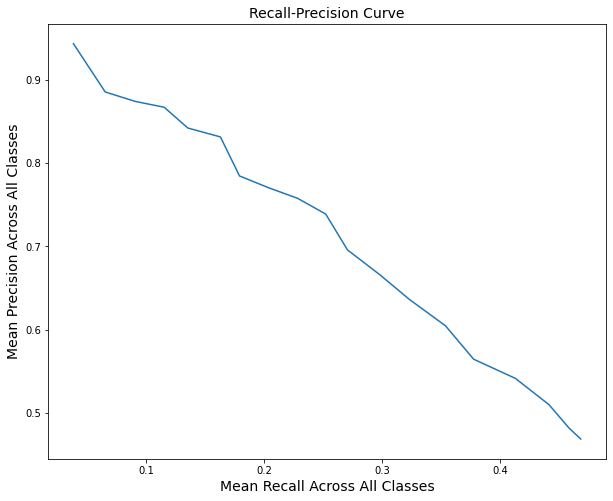

In [76]:
threshold = 0.5
print("{0:.1f}% of predictions with a class likelihood above {1}".format(100*sum(y_probs_valid>threshold)/len(y_probs_valid), threshold))

precisions, recalls = [], []
for threshold in np.linspace(0, 0.95, 20):
  y_pred_threshold = y_pred_valid[y_probs_valid > threshold]
  y_true_threshold = y_valid_subset[y_probs_valid > threshold]

  y_pred_threshold_complete = [y if y_probs_valid[i] > threshold else -1 for i,y in enumerate(y_pred_valid)]

  precisions.append(precision_score(y_true_threshold, y_pred_threshold, average='micro'))
  recalls.append(recall_score(y_valid_subset, y_pred_threshold_complete, average='micro'))

plt.figure(figsize=(10,8))
plt.plot(recalls, precisions)
plt.title("Recall-Precision Curve", size=14)
plt.xlabel("Mean Recall Across All Classes",size=14)
plt.ylabel("Mean Precision Across All Classes", size=14)

              precision    recall  f1-score   support

           0       0.36      0.39      0.37        70
           1       0.40      0.70      0.51        70
           2       0.54      0.49      0.51        70
           3       0.42      0.51      0.46        70
           4       0.51      0.68      0.59        60
           5       0.55      0.51      0.53        70
           6       0.53      0.71      0.61        70
           7       0.28      0.40      0.33        50
           8       0.47      0.24      0.32        70
           9       0.42      0.43      0.43        70
          10       0.70      0.61      0.66        70
          12       0.67      0.31      0.43        70
          13       0.47      0.39      0.43        70
          14       0.49      0.39      0.43        70
          15       0.54      0.64      0.59        70
          16       0.49      0.59      0.54        70
          17       0.57      0.37      0.45        70
          18       0.34    

<Figure size 432x432 with 0 Axes>

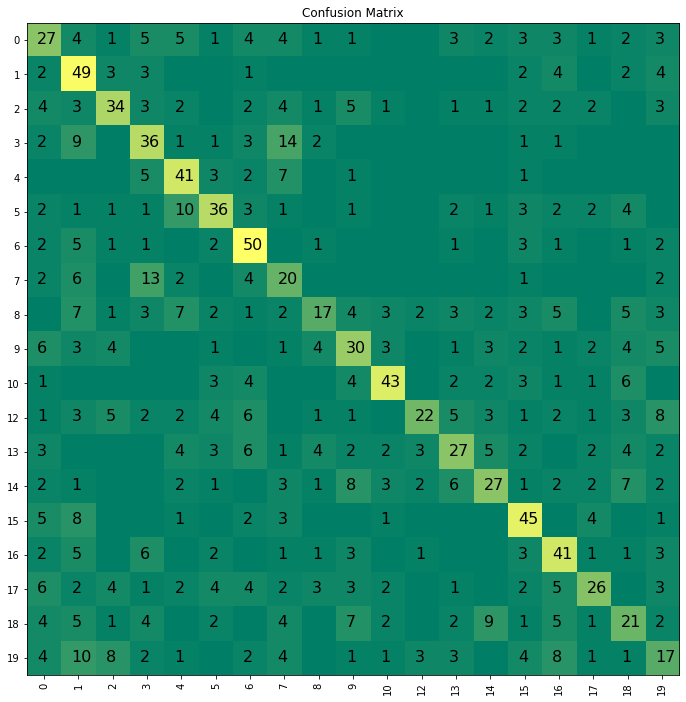

In [79]:
print_results(y_valid_subset, y_pred_valid, np.unique(y_valid_subset))

### Test verification approach

In [ ]:
# ### Test performance when number of partipicants/identities to predict is lower.
# n_classes = 1
# x_train_subset = x_train[y_train < n_classes]
# y_train_subset = y_train[y_train < n_classes]
# x_valid_subset = x_valid[y_valid < n_classes]
# y_valid_subset = y_valid[y_valid < n_classes]

params = {'kernel':['rbf'], 'C':[10.0], 'gamma':['scale'], 'degree':[2]}
# params = {'kernel':['rbf'], 'C':[10.0], 'gamma':['scale'], 'degree':[2]}

chosen_model = 17

prev=time()

# svm = SVM_one_v_all(random_state=0, verification=True)

# svm.fit(x_train, y_train)
train_pred = svm.predict(x_train, class_ver=1)
valid_pred = svm.predict(x_valid, class_ver=1)

y_train_true = y_train ==1
y_valid_true = y_valid==1

print_results(y_valid_true, valid_pred, np.unique(y_valid_true))

print(round(time()-prev, 5), " seconds")

In [ ]:
id_train_df = pd.DataFrame(id_train, columns=['Subject', 'Date','Run','Task','Trial'])

# Get the minimum date for each subject.
df = id_train_df.groupby(by='Subject', as_index=False).max('Date')[['Subject','Date']]
min_dates = df.astype(str).agg('-'.join, axis=1).values                                 # Convert (Date) to string and concatenate the Subject and Date

rel_ind = np.in1d(id_train[:,0] + '-' + id_train[:,1].astype(str), min_dates)

x_train_1session = x_train[rel_ind]
y_train_1session = y_train[rel_ind]

rel_ind = np.in1d(id_valid[:,0] + '-' + id_valid[:,1].astype(str), min_dates)

x_valid_1session = x_valid[rel_ind]
y_valid_1session = y_valid[rel_ind]